# Phân Cụm Các Loại Ô Tô (Clustering Analysis)

Notebook này minh họa cách sử dụng các module trong thư mục `src` để thực hiện phân cụm (clustering) trên dữ liệu xe ô tô. Phân cụm giúp phân loại các xe thành các nhóm tương đồng dựa trên các đặc điểm của chúng mà không cần nhãn đã biết trước.

## Mục tiêu
1. Nạp và tiền xử lý dữ liệu xe từ tệp CSV
2. Sử dụng các module từ thư mục `src` để tạo đặc trưng
3. Thực hiện phân cụm bằng các thuật toán K-Means, Hierarchical và DBSCAN
4. Trực quan hóa các cụm và phân tích kết quả

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Thêm thư mục gốc vào sys.path để import module từ src
sys.path.insert(0, os.path.abspath('../'))
from src.data_loader import load_raw_data
from src.preprocessing import handle_missing_values, normalize_features, handle_outliers
from src.feature_engineering import create_age_feature
from src.clustering import (train_kmeans, train_hierarchical_clustering, train_dbscan,
                          find_optimal_clusters, assign_cluster_labels)
from src.visualization import plot_clusters

# Cài đặt để hiển thị biểu đồ
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True

## 1. Nạp và khám phá dữ liệu

Đầu tiên, chúng ta sẽ nạp dữ liệu xe từ tệp CSV sử dụng hàm `load_raw_data` từ module `src.data_loader`.

In [2]:
# Đường dẫn đến dữ liệu
data_path = '../data/processed/enhanced_car_data.csv'

# Nạp dữ liệu sử dụng hàm từ module src.data_loader
try:
    df = load_raw_data(data_path)
    print(f"Đã nạp dữ liệu với {df.shape[0]} dòng và {df.shape[1]} cột")
except FileNotFoundError:
    print(f"Không tìm thấy file {data_path}. Sử dụng dữ liệu từ 'used_cars.csv'")
    # Thử với file used_cars.csv
    df = load_raw_data('../used_cars.csv')
    print(f"Đã nạp dữ liệu với {df.shape[0]} dòng và {df.shape[1]} cột")

# Hiển thị vài dòng đầu tiên của dữ liệu
df.head()

Đã nạp dữ liệu với 13453 dòng và 16 cột


,url,name,brand,price,year,origin,transmission,body_type,engine,drive,mileage_km,seats,doors,exterior_color,interior_color,condition
0,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C250 Exclusive,Mercedes,645 Triệu,2016,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,RFD - Dẫn động cầu sau,90000,5,4,Trắng,Đen,Xe đã dùng
1,https://bonbanh.com/xe-vinfast-vf9-plus-2023-6...,VinFast VF9 Plus,Vinfast,920 Triệu,2023,Lắp ráp trong nước,Số tự động,SUV,Điện 0.2 L,AWD - 4 bánh toàn thời gian,50000,6,5,Đỏ,Nâu,Xe đã dùng
2,https://bonbanh.com/xe-mercedes_benz-glc-300-4...,Mercedes Benz GLC 4Matic,Mercedes,1 Tỷ 679 Triệu,2022,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.0 L,AWD - 4 bánh toàn thời gian,26600,5,5,Đen,Đen,Xe đã dùng
3,https://bonbanh.com/xe-mitsubishi-xpander-cros...,Mitsubishi Xpander Cross,Mitsubishi,579 Triệu,2023,Nhập khẩu,Số tự động,SUV,Xăng 1.5 L,FWD - Dẫn động cầu trước,62000,7,5,Cam,Đen,Xe đã dùng
4,https://bonbanh.com/xe-ford-explorer-limited-2...,Ford Explorer Limited EcoBoost,Ford,1 Tỷ 100 Triệu,2019,Nhập khẩu,Số tự động,SUV,Xăng 2.3 L,AWD - 4 bánh toàn thời gian,60000,7,5,Đen,Đen,Xe đã dùng


In [3]:
# Khám phá thông tin của dữ liệu
print("Thông tin về dữ liệu:")
df.info()

# Thống kê mô tả
print("\nThống kê mô tả:")
df.describe()

Thông tin về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13453 entries, 0 to 13452
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             13453 non-null  object
 1   name            13453 non-null  object
 2   brand           13453 non-null  object
 3   price           13453 non-null  object
 4   year            13453 non-null  int64 
 5   origin          13453 non-null  object
 6   transmission    13453 non-null  object
 7   body_type       13453 non-null  object
 8   engine          13453 non-null  object
 9   drive           13453 non-null  object
 10  mileage_km      13453 non-null  int64 
 11  seats           13453 non-null  int64 
 12  doors           13453 non-null  int64 
 13  exterior_color  13453 non-null  object
 14  interior_color  13453 non-null  object
 15  condition       13453 non-null  object
dtypes: int64(4), object(12)
memory usage: 1.6+ MB

Thống kê mô tả:


,year,mileage_km,seats,doors
count,13453.000000,1.345300e+04,13453.000000,13453.000000
mean,2018.934364,9.625784e+04,5.601130,4.631829
std,4.383092,2.238369e+06,1.771299,0.552577
min,1989.000000,0.000000e+00,0.000000,2.000000
25%,2016.000000,2.000000e+04,5.000000,4.000000
50%,2020.000000,5.000000e+04,5.000000,5.000000
75%,2022.000000,8.100000e+04,7.000000,5.000000
max,2025.000000,2.500000e+08,47.000000,5.000000


## 2. Tiền xử lý dữ liệu

Tiếp theo, chúng ta sẽ tiền xử lý dữ liệu bằng các hàm từ module `src.preprocessing` và `src.feature_engineering`:

1. Xử lý giá trị thiếu (missing values)
2. Xử lý giá trị ngoại lai (outliers)
3. Tạo các đặc trưng mới
4. Chuẩn hóa các đặc trưng số

In [4]:
# Hàm tiện ích để chuyển đổi giá thành số (triệu đồng)
def convert_price_to_number(price_text):
    """Chuyển đổi giá từ dạng văn bản (vd: 1 Tỷ 599 Triệu) sang số (đơn vị: triệu)."""
    import re
    price_text = str(price_text).strip()
    ty_pattern = r'(\d+)\s*Tỷ'
    trieu_pattern = r'(\d+)\s*Triệu'
    
    price_in_million = 0
    
    # Tìm số tỷ
    ty_match = re.search(ty_pattern, price_text)
    if ty_match:
        price_in_million += int(ty_match.group(1)) * 1000
    
    # Tìm số triệu
    trieu_match = re.search(trieu_pattern, price_text)
    if trieu_match:
        price_in_million += int(trieu_match.group(1))
    
    return price_in_million

# Chuyển đổi giá thành số
if 'price' in df.columns and 'price_million' not in df.columns:
    df['price_million'] = df['price'].apply(convert_price_to_number)
    print("Đã chuyển đổi cột 'price' thành 'price_million'")
    
# Kiểm tra các cột có giá trị thiếu
print("\nSố lượng giá trị thiếu trong mỗi cột:")
print(df.isna().sum())

Đã chuyển đổi cột 'price' thành 'price_million'

Số lượng giá trị thiếu trong mỗi cột:
url               0
name              0
brand             0
price             0
year              0
origin            0
transmission      0
body_type         0
engine            0
drive             0
mileage_km        0
seats             0
doors             0
exterior_color    0
interior_color    0
condition         0
price_million     0
dtype: int64


In [5]:
# Xử lý giá trị thiếu sử dụng hàm từ src.preprocessing
print("Xử lý giá trị thiếu...")
df_clean = handle_missing_values(df, strategy='median')

# Tạo đặc trưng tuổi xe sử dụng hàm từ src.feature_engineering
if 'year' in df_clean.columns and 'car_age' not in df_clean.columns:
    print("Tạo đặc trưng tuổi xe...")
    df_clean = create_age_feature(df_clean, 'year')

# Chuyển đổi số km đã đi nếu cần
def convert_mileage(mileage_text):
    import re
    if pd.isna(mileage_text) or not mileage_text:
        return np.nan
    if isinstance(mileage_text, (int, float)):
        return mileage_text
    # Xóa các ký tự không phải số
    mileage_str = re.sub(r'[^0-9]', '', str(mileage_text))
    return float(mileage_str) if mileage_str else np.nan

if 'mileage' in df_clean.columns and 'mileage_km' not in df_clean.columns:
    print("Chuyển đổi cột 'mileage'...")
    df_clean['mileage_km'] = df_clean['mileage'].apply(convert_mileage)
    
# Xử lý giá trị ngoại lai cho các đặc trưng số
numeric_columns = df_clean.select_dtypes(include=['number']).columns.tolist()
print(f"Xử lý giá trị ngoại lai cho các cột: {numeric_columns}")
df_clean = handle_outliers(df_clean, numeric_columns, method='iqr')

# Hiển thị kết quả sau khi tiền xử lý
print("\nDữ liệu sau khi tiền xử lý:")
df_clean.info()

Xử lý giá trị thiếu...
Tạo đặc trưng tuổi xe...
Xử lý giá trị ngoại lai cho các cột: ['year', 'mileage_km', 'seats', 'doors', 'price_million', 'car_age']

Dữ liệu sau khi tiền xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13453 entries, 0 to 13452
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             13453 non-null  object 
 1   name            13453 non-null  object 
 2   brand           13453 non-null  object 
 3   price           13453 non-null  object 
 4   year            13453 non-null  float64
 5   origin          13453 non-null  object 
 6   transmission    13453 non-null  object 
 7   body_type       13453 non-null  object 
 8   engine          13453 non-null  object 
 9   drive           13453 non-null  object 
 10  mileage_km      13453 non-null  float64
 11  seats           13453 non-null  float64
 12  doors           13453 non-null  float64
 13  exterior_color  13453 non-nu

## 3. Chuẩn bị dữ liệu cho phân cụm

Phân cụm thường hoạt động tốt nhất với các đặc trưng số đã được chuẩn hóa. Chúng ta sẽ:
1. Chọn các đặc trưng số quan trọng
2. Chuẩn hóa dữ liệu bằng StandardScaler
3. Sử dụng PCA để giảm chiều dữ liệu (tùy chọn)

Phân cụm sẽ được thực hiện dựa trên các đặc trưng như giá, năm sản xuất, số km đã đi, và dung tích động cơ.

In [6]:
# Chọn các đặc trưng số cho phân cụm
features_for_clustering = ['price_million', 'year', 'mileage_km']

# Thêm engine_capacity nếu có
if 'engine_capacity' in df_clean.columns:
    features_for_clustering.append('engine_capacity')
elif 'engine' in df_clean.columns:
    # Trích xuất dung tích động cơ
    import re
    def extract_engine_capacity(engine_text):
        if pd.isna(engine_text) or not engine_text:
            return np.nan
        capacity_match = re.search(r'(\d+\.\d+|\d+)\s*L', str(engine_text))
        if capacity_match:
            return float(capacity_match.group(1))
        return np.nan
    
    print("Trích xuất dung tích động cơ...")
    df_clean['engine_capacity'] = df_clean['engine'].apply(extract_engine_capacity)
    features_for_clustering.append('engine_capacity')

# Thêm car_age nếu có
if 'car_age' in df_clean.columns:
    features_for_clustering.append('car_age')

# Chọn các hàng không có giá trị thiếu cho các đặc trưng được chọn
df_cluster = df_clean.dropna(subset=features_for_clustering)
print(f"Dữ liệu cho phân cụm có {df_cluster.shape[0]} dòng và {df_cluster.shape[1]} cột")
print(f"Các đặc trưng được chọn: {features_for_clustering}")

# Chuẩn hóa dữ liệu sử dụng hàm từ src.preprocessing
X_cluster = df_cluster[features_for_clustering]
X_scaled = normalize_features(X_cluster, features_for_clustering, method='zscore')

# Hiển thị dữ liệu sau khi chuẩn hóa
X_scaled.describe()

Trích xuất dung tích động cơ...
Dữ liệu cho phân cụm có 13134 dòng và 19 cột
Các đặc trưng được chọn: ['price_million', 'year', 'mileage_km', 'engine_capacity', 'car_age']


,price_million,year,mileage_km,engine_capacity,car_age
count,1.313400e+04,1.313400e+04,1.313400e+04,1.313400e+04,1.313400e+04
mean,5.193551e-17,-1.506130e-15,-4.977153e-17,-1.882662e-16,-4.327959e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.226148e+00,-2.814567e+00,-1.326014e+00,-2.283247e+00,-1.446786e+00
25%,-7.226621e-01,-6.838908e-01,-8.618361e-01,-6.782428e-01,-7.365602e-01
50%,-4.271626e-01,2.630765e-01,-1.191510e-01,-2.502417e-01,-2.630765e-01
75%,4.422880e-01,7.365602e-01,6.003251e-01,2.847597e-01,6.838908e-01
max,2.110156e+00,1.446786e+00,2.677522e+00,4.885772e+00,2.814567e+00


Tỷ lệ phương sai giải thích được: [0.50671149 0.31838354]
Tổng tỷ lệ: 0.83


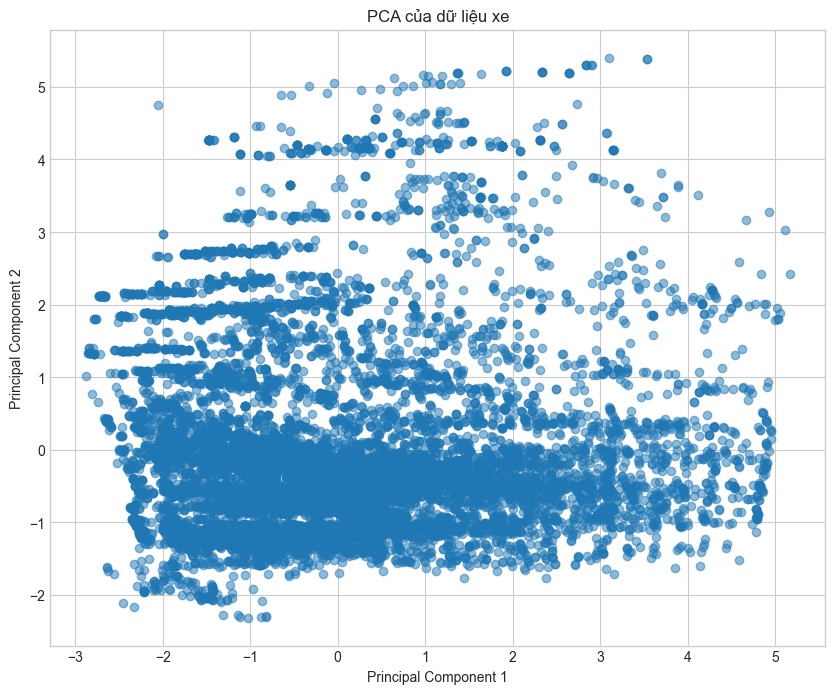

In [7]:
# Giảm chiều dữ liệu bằng PCA (tùy chọn)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Hiển thị tỷ lệ phương sai giải thích được
explained_variance = pca.explained_variance_ratio_
print(f"Tỷ lệ phương sai giải thích được: {explained_variance}")
print(f"Tổng tỷ lệ: {sum(explained_variance):.2f}")

# Tạo DataFrame cho dữ liệu PCA để dễ dàng trực quan hóa
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Biểu đồ phân tán cho dữ liệu đã giảm chiều
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.title('PCA của dữ liệu xe')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 4. Tìm số cụm tối ưu

Trước khi áp dụng thuật toán K-Means, chúng ta cần xác định số lượng cụm (K) thích hợp. Chúng ta sẽ sử dụng phương pháp "Elbow Method" và Silhouette Score.

Số cụm tối ưu dựa trên điểm silhouette: 3


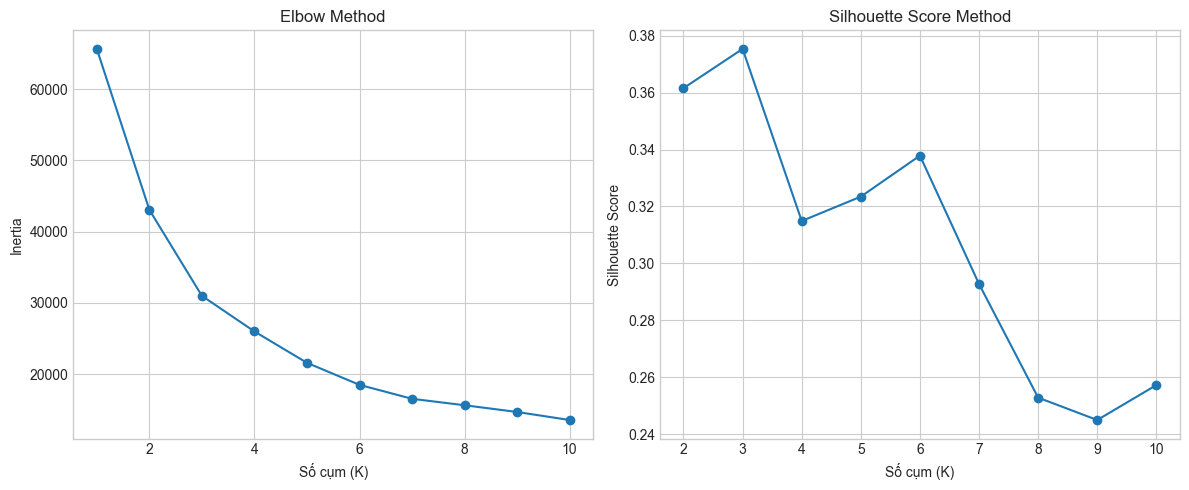

In [8]:
# Tìm số cụm tối ưu sử dụng hàm từ src.clustering
optimal_clusters, silhouette_scores = find_optimal_clusters(X_scaled, max_clusters=10)

print(f"Số cụm tối ưu dựa trên điểm silhouette: {optimal_clusters}")

# Vẽ biểu đồ Elbow Method bằng cách tính tổng bình phương khoảng cách
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.title('Elbow Method')
plt.xlabel('Số cụm (K)')
plt.ylabel('Inertia')
plt.grid(True)

# Vẽ biểu đồ Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'o-')
plt.title('Silhouette Score Method')
plt.xlabel('Số cụm (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Áp dụng K-Means Clustering

Bây giờ chúng ta sẽ áp dụng thuật toán K-Means với số lượng cụm đã xác định từ bước trước.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28168\3072434565.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['kmeans_cluster'] = df_kmeans['cluster']
d:\Machineleaning_dudoanoto\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Phân bố của các cụm K-Means:
kmeans_cluster
1    7177
2    3667
0    2290
Name: count, dtype: int64


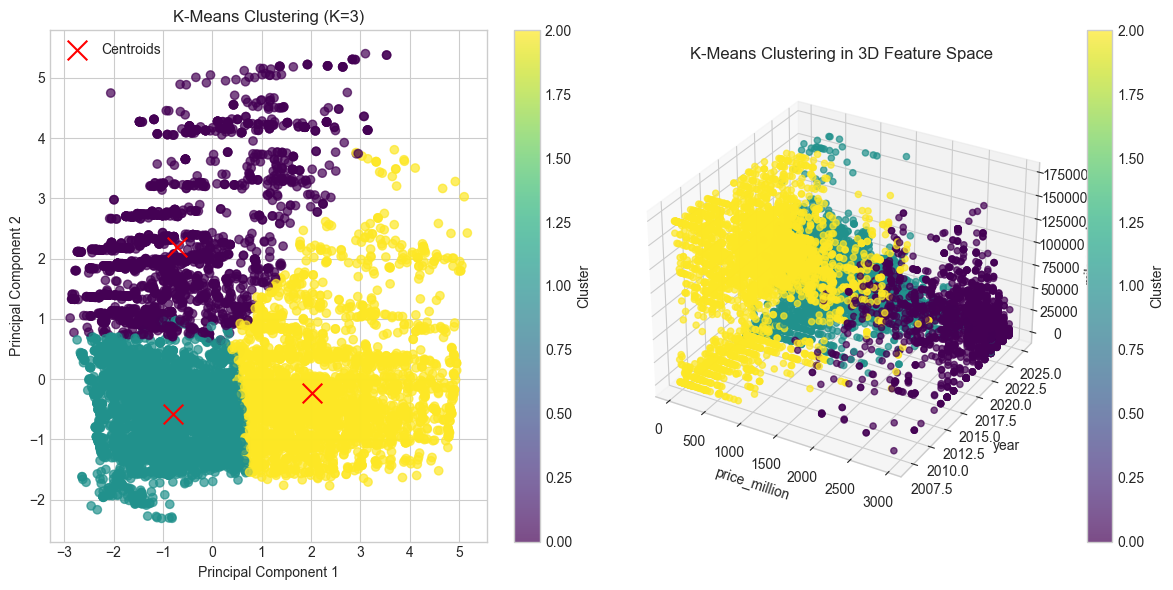

In [9]:
# Huấn luyện mô hình K-Means sử dụng hàm từ src.clustering
n_clusters = optimal_clusters  # Sử dụng số cụm tối ưu đã xác định
kmeans_model = train_kmeans(X_scaled, n_clusters=n_clusters)

# Gán nhãn cụm cho dữ liệu
df_kmeans = assign_cluster_labels(X_scaled, kmeans_model)

# Kết hợp nhãn cụm với dữ liệu gốc
df_cluster['kmeans_cluster'] = df_kmeans['cluster']

# Hiển thị phân bố của các cụm
print("Phân bố của các cụm K-Means:")
print(df_cluster['kmeans_cluster'].value_counts())

# Trực quan hóa kết quả phân cụm trên dữ liệu đã giảm chiều
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_cluster['kmeans_cluster'], 
           cmap='viridis', alpha=0.7)
plt.title(f'K-Means Clustering (K={n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')

# Vẽ tâm cụm
centroids_pca = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, 
           color='red', label='Centroids')
plt.legend()

# Vẽ biểu đồ phân tán 3D (nếu có đủ đặc trưng)
if len(features_for_clustering) >= 3:
    from mpl_toolkits.mplot3d import Axes3D
    
    plt.subplot(1, 2, 2, projection='3d')
    ax = plt.gca()
    scatter3d = ax.scatter(df_cluster[features_for_clustering[0]], 
                          df_cluster[features_for_clustering[1]], 
                          df_cluster[features_for_clustering[2]],
                          c=df_cluster['kmeans_cluster'], cmap='viridis', alpha=0.7)
    plt.title('K-Means Clustering in 3D Feature Space')
    ax.set_xlabel(features_for_clustering[0])
    ax.set_ylabel(features_for_clustering[1])
    ax.set_zlabel(features_for_clustering[2])
    plt.colorbar(scatter3d, label='Cluster')

plt.tight_layout()
plt.show()

In [10]:
# Phân tích đặc điểm của từng cụm
cluster_analysis = df_cluster.groupby('kmeans_cluster').agg({
    'price_million': ['mean', 'min', 'max'],
    'year': ['mean', 'min', 'max'],
    'mileage_km': ['mean', 'min', 'max'],
    'brand': lambda x: x.value_counts().index[0] if not x.empty else None
})

print("\nĐặc điểm của từng cụm:")
print(cluster_analysis)

# Đặt tên cho các cụm dựa trên đặc điểm của chúng
def assign_cluster_name(cluster_id):
    price_mean = cluster_analysis.loc[cluster_id, ('price_million', 'mean')]
    year_mean = cluster_analysis.loc[cluster_id, ('year', 'mean')]
    
    price_category = 'Cao' if price_mean > 1000 else 'Trung bình' if price_mean > 500 else 'Thấp'
    age_category = 'Mới' if year_mean > 2020 else 'Trung niên' if year_mean > 2015 else 'Cũ'
    
    return f"Xe {age_category} - Giá {price_category}"

cluster_names = {i: assign_cluster_name(i) for i in range(n_clusters)}
print("\nTên gợi ý cho các cụm:")
for cluster_id, name in cluster_names.items():
    print(f"Cụm {cluster_id}: {name}")


Đặc điểm của từng cụm:
               price_million                        year                  \
                        mean    min     max         mean     min     max   
kmeans_cluster                                                             
0                2737.589083  750.0  2957.5  2019.804803  2007.0  2025.0   
1                 862.675212   95.0  2957.5  2021.245088  2015.0  2025.0   
2                 544.862285   22.0  2690.0  2013.704936  2007.0  2021.0   

                  mileage_km                    brand  
                        mean  min       max  <lambda>  
kmeans_cluster                                         
0               45024.035371  0.0  172500.0     Lexus  
1               42157.726209  0.0  172500.0  Mercedes  
2               94007.344151  0.0  172500.0    Toyota  

Tên gợi ý cho các cụm:
Cụm 0: Xe Trung niên - Giá Cao
Cụm 1: Xe Mới - Giá Trung bình
Cụm 2: Xe Cũ - Giá Trung bình


## 6. Thử nghiệm với các thuật toán phân cụm khác

Ngoài K-Means, chúng ta sẽ thử nghiệm với các thuật toán phân cụm khác như Hierarchical Clustering (Agglomerative Clustering) và DBSCAN.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28168\10702249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['hier_cluster'] = hier_model.labels_


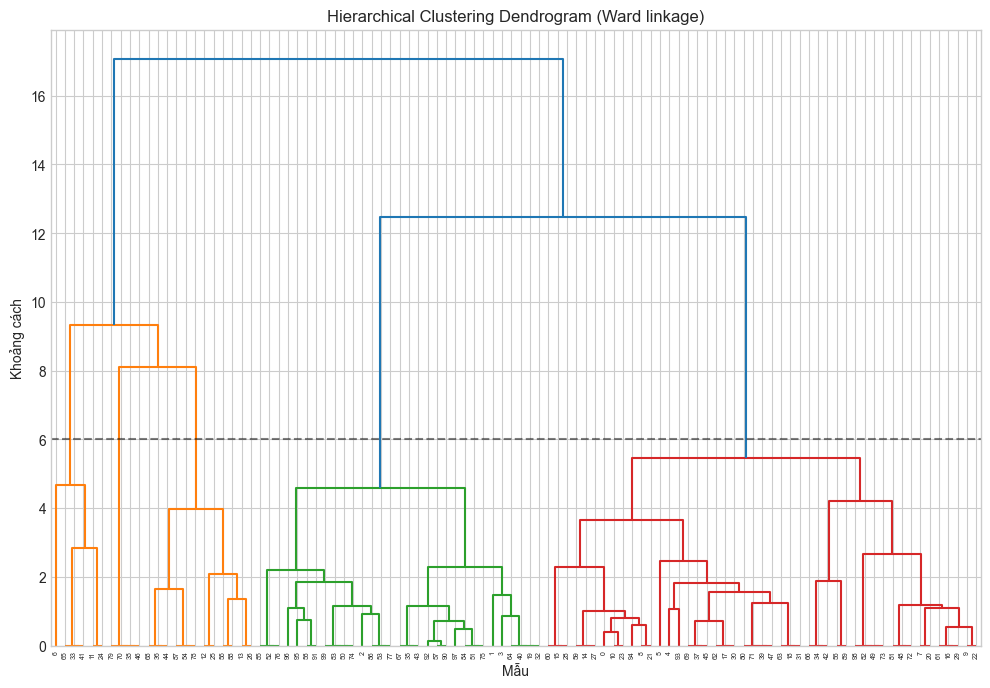


So sánh kết quả phân cụm giữa K-Means và Hierarchical Clustering:
Adjusted Rand Index: 0.6856
Adjusted Mutual Information: 0.6195


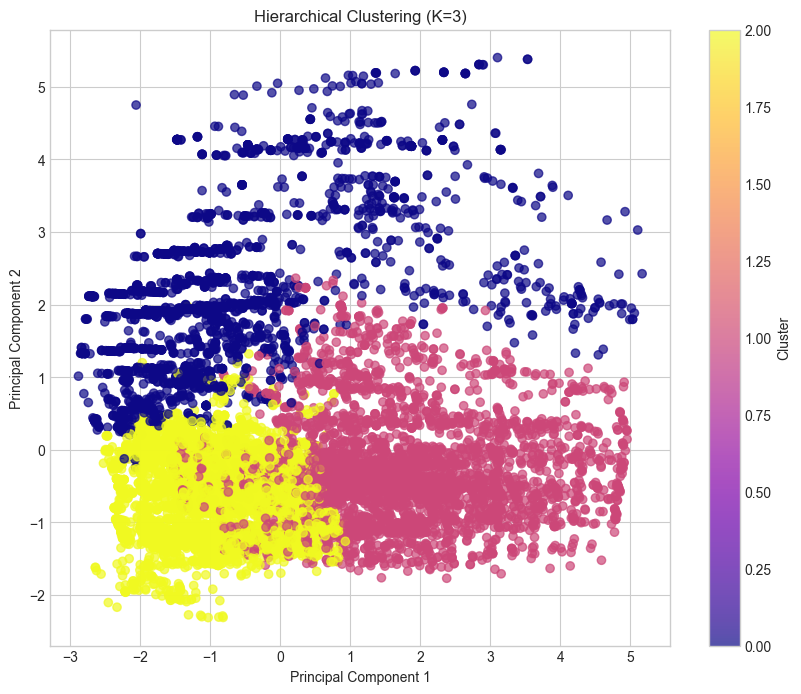

In [11]:
# Hierarchical Clustering sử dụng hàm từ src.clustering
hier_model = train_hierarchical_clustering(X_scaled, n_clusters=n_clusters)

# Gán nhãn cụm cho dữ liệu
df_cluster['hier_cluster'] = hier_model.labels_

# Vẽ dendrogram cho hierarchical clustering (giới hạn đến 100 mẫu đầu tiên để dễ nhìn)
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(12, 8))
sample_size = min(100, len(X_scaled))
X_sample = X_scaled.iloc[:sample_size]

# Tính ma trận linkage
Z = linkage(X_sample, 'ward')

# Vẽ dendrogram
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Ward linkage)')
plt.xlabel('Mẫu')
plt.ylabel('Khoảng cách')
plt.axhline(y=6, c='k', linestyle='--', alpha=0.5)
plt.show()

# So sánh kết quả phân cụm giữa K-Means và Hierarchical Clustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

print("\nSo sánh kết quả phân cụm giữa K-Means và Hierarchical Clustering:")
ari = adjusted_rand_score(df_cluster['kmeans_cluster'], df_cluster['hier_cluster'])
ami = adjusted_mutual_info_score(df_cluster['kmeans_cluster'], df_cluster['hier_cluster'])
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Adjusted Mutual Information: {ami:.4f}")

# Trực quan hóa kết quả phân cụm Hierarchical
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_cluster['hier_cluster'], 
                     cmap='plasma', alpha=0.7)
plt.title(f'Hierarchical Clustering (K={n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

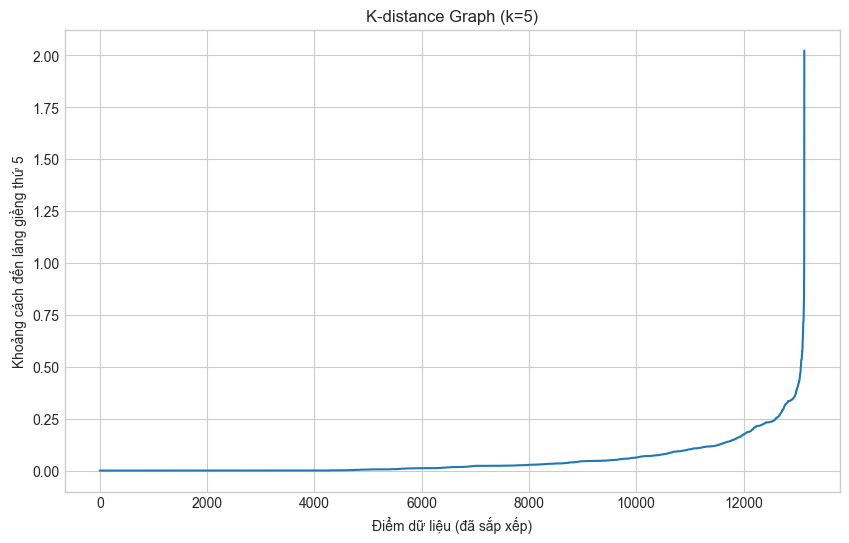

Áp dụng DBSCAN với eps=0.5 và min_samples=5


C:\Users\ASUS\AppData\Local\Temp\ipykernel_28168\849601701.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['dbscan_cluster'] = dbscan_model.labels_


Số cụm được tìm thấy bởi DBSCAN: 28
Số điểm nhiễu: 196


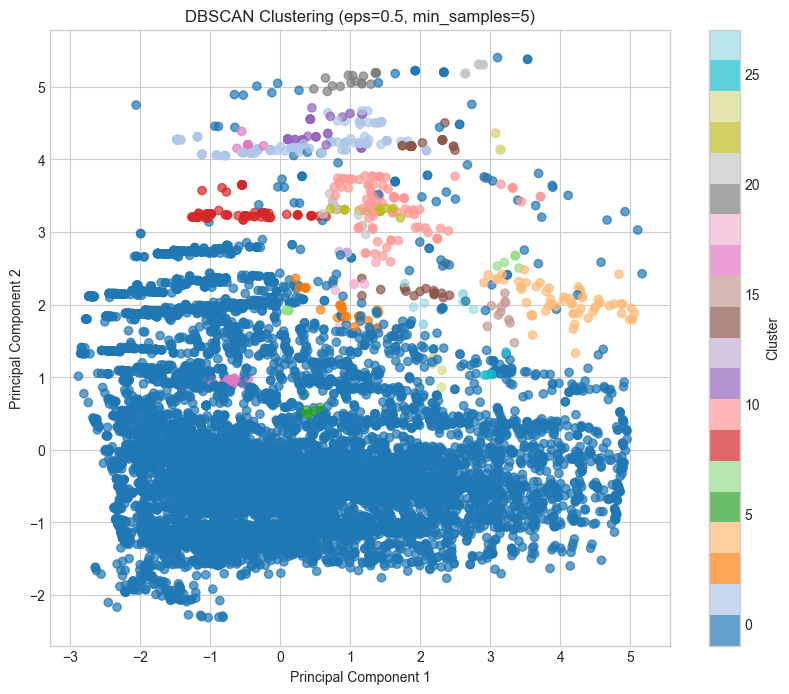

In [12]:
# DBSCAN Clustering sử dụng hàm từ src.clustering
# DBSCAN không cần số lượng cụm từ trước, nhưng cần tham số eps và min_samples
# Có thể tìm eps bằng k-distance graph
from sklearn.neighbors import NearestNeighbors

# Tính k-nearest neighbors
k = 5  # Thường là 2 * dims
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# Vẽ k-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # Lấy khoảng cách đến điểm thứ k (bỏ qua chính nó)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph (k={})'.format(k))
plt.xlabel('Điểm dữ liệu (đã sắp xếp)')
plt.ylabel('Khoảng cách đến láng giềng thứ {}'.format(k))
plt.grid(True)
plt.show()

# Chọn giá trị "khuỷu" từ đồ thị làm eps
eps = 0.5  # Điều chỉnh dựa trên k-distance graph
min_samples = 5  # Thường là 2 * dims

print(f"Áp dụng DBSCAN với eps={eps} và min_samples={min_samples}")
dbscan_model = train_dbscan(X_scaled, eps=eps, min_samples=min_samples)

# Gán nhãn cụm cho dữ liệu
df_cluster['dbscan_cluster'] = dbscan_model.labels_

# Số lượng cụm tìm được (không tính nhiễu -1)
n_clusters_dbscan = len(set(dbscan_model.labels_)) - (1 if -1 in dbscan_model.labels_ else 0)
print(f"Số cụm được tìm thấy bởi DBSCAN: {n_clusters_dbscan}")
print(f"Số điểm nhiễu: {list(dbscan_model.labels_).count(-1)}")

# Trực quan hóa kết quả phân cụm DBSCAN
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_cluster['dbscan_cluster'], 
                     cmap='tab20', alpha=0.7)
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

## 7. Phân tích và trực quan hóa các cụm

Bây giờ chúng ta sẽ phân tích sâu hơn về các cụm đã được tạo ra. Chúng ta sẽ sử dụng các module từ `src.visualization` để trực quan hóa kết quả.

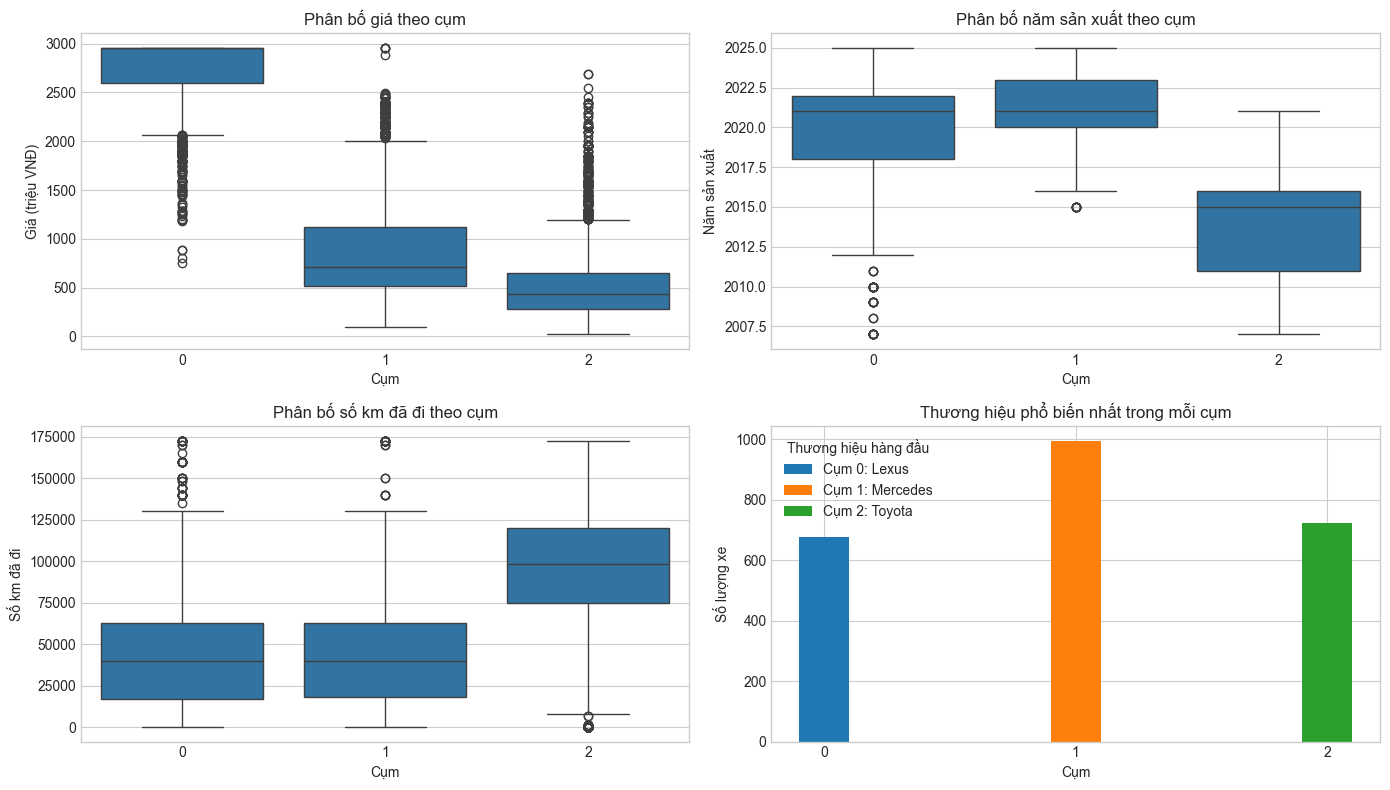

In [13]:
# Phân tích chi tiết cho các cụm K-means
# Sử dụng hàm từ src.visualization để trực quan hóa

# Phân bố giá theo cụm
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='kmeans_cluster', y='price_million', data=df_cluster)
plt.title('Phân bố giá theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Giá (triệu VNĐ)')

# Phân bố năm sản xuất theo cụm
plt.subplot(2, 2, 2)
sns.boxplot(x='kmeans_cluster', y='year', data=df_cluster)
plt.title('Phân bố năm sản xuất theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Năm sản xuất')

# Phân bố số km đã đi theo cụm
plt.subplot(2, 2, 3)
sns.boxplot(x='kmeans_cluster', y='mileage_km', data=df_cluster)
plt.title('Phân bố số km đã đi theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Số km đã đi')

# Phân bố thương hiệu xe theo cụm (top 5 của mỗi cụm)
plt.subplot(2, 2, 4)
top_brands = {}
for cluster_id in range(n_clusters):
    brands_in_cluster = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]['brand'].value_counts().nlargest(3)
    top_brands[cluster_id] = brands_in_cluster

# Vẽ biểu đồ cột cho top brands
bar_width = 0.2
positions = np.arange(n_clusters)

for i, (cluster, brands) in enumerate(top_brands.items()):
    plt.bar(positions[i], brands.iloc[0], bar_width, label=f'Cụm {i}: {brands.index[0]}')
    
plt.title('Thương hiệu phổ biến nhất trong mỗi cụm')
plt.xlabel('Cụm')
plt.ylabel('Số lượng xe')
plt.xticks(positions)
plt.legend(title='Thương hiệu hàng đầu')

plt.tight_layout()
plt.show()

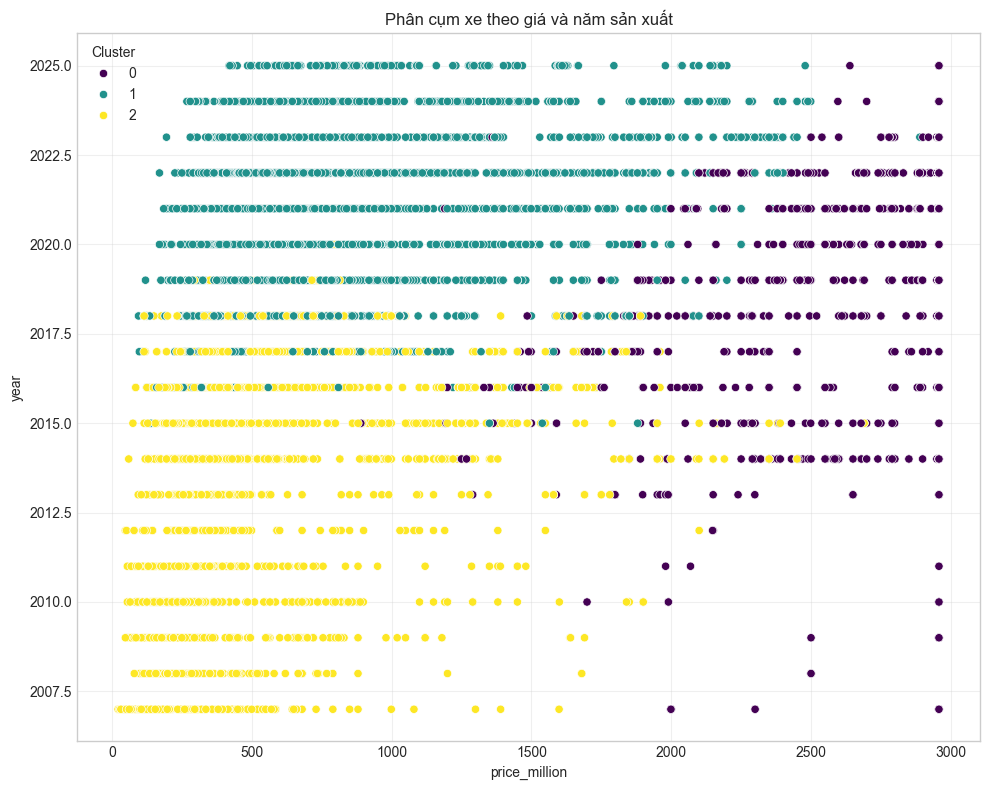

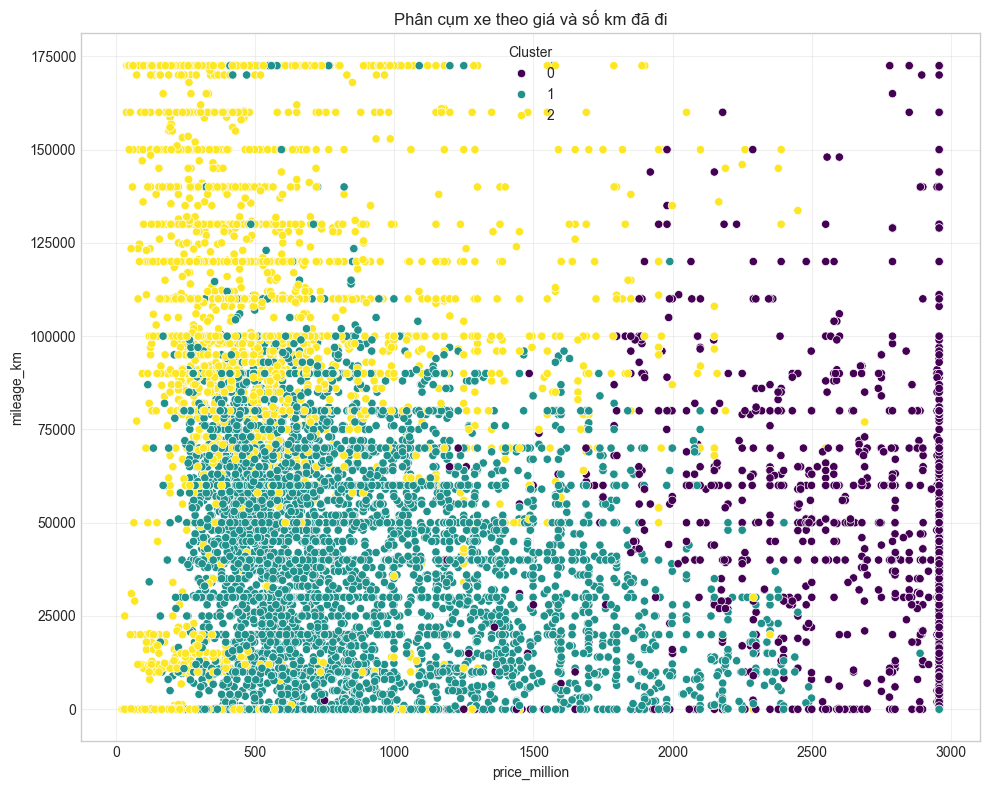

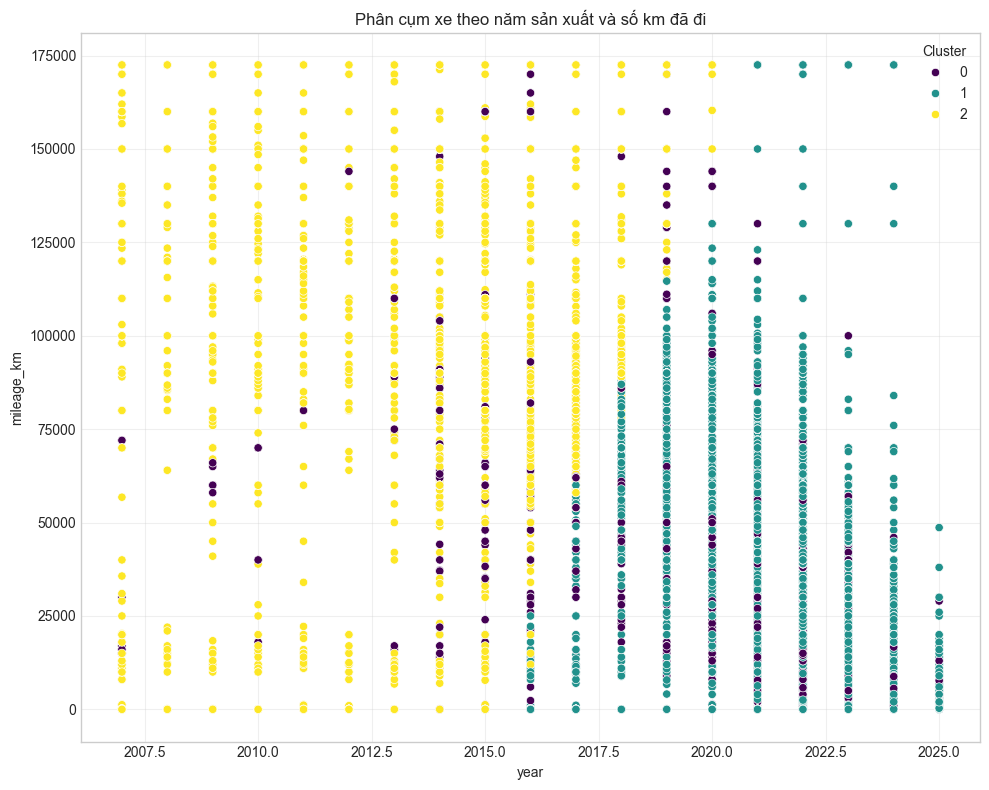

In [14]:
# Trực quan hóa mối quan hệ giữa các đặc trưng và cụm
from src.visualization import plot_clusters

# Mối quan hệ giữa giá và năm sản xuất
plot_clusters(df_cluster, 'price_million', 'year', 'kmeans_cluster',
             title='Phân cụm xe theo giá và năm sản xuất')

# Mối quan hệ giữa giá và số km đã đi
if 'mileage_km' in df_cluster.columns:
    plot_clusters(df_cluster, 'price_million', 'mileage_km', 'kmeans_cluster',
                 title='Phân cụm xe theo giá và số km đã đi')
    
# Mối quan hệ giữa năm sản xuất và số km đã đi
if 'mileage_km' in df_cluster.columns:
    plot_clusters(df_cluster, 'year', 'mileage_km', 'kmeans_cluster',
                 title='Phân cụm xe theo năm sản xuất và số km đã đi')

## 8. Kết luận và lưu mô hình

Từ phân tích phân cụm, chúng ta có thể rút ra các kết luận về các phân khúc xe trong thị trường, cách giá xe liên quan đến các đặc điểm của xe, và xu hướng của thị trường.

In [15]:
# Lưu mô hình K-means sử dụng hàm từ src.clustering
from src.clustering import save_clustering_model
import os

# Tạo thư mục để lưu mô hình nếu chưa tồn tại
models_dir = '../data/processed/models/clustering'
os.makedirs(models_dir, exist_ok=True)

# Lưu mô hình K-means
kmeans_model_path = os.path.join(models_dir, 'kmeans_model.pkl')
save_clustering_model(kmeans_model, kmeans_model_path)
print(f"Đã lưu mô hình K-means vào {kmeans_model_path}")

# Lưu mô hình Hierarchical Clustering
hier_model_path = os.path.join(models_dir, 'hierarchical_model.pkl')
save_clustering_model(hier_model, hier_model_path)
print(f"Đã lưu mô hình Hierarchical Clustering vào {hier_model_path}")

# Lưu thông tin về các cụm
cluster_info_path = os.path.join(models_dir, 'cluster_info.csv')
cluster_analysis.to_csv(cluster_info_path)
print(f"Đã lưu thông tin cụm vào {cluster_info_path}")

# Lưu dữ liệu đã được gán nhãn cụm
labeled_data_path = os.path.join(models_dir, 'car_data_with_clusters.csv')
df_cluster.to_csv(labeled_data_path, index=False)
print(f"Đã lưu dữ liệu đã gán nhãn cụm vào {labeled_data_path}")

Đã lưu mô hình K-means vào ../data/processed/models/clustering\kmeans_model.pkl
Đã lưu mô hình Hierarchical Clustering vào ../data/processed/models/clustering\hierarchical_model.pkl
Đã lưu thông tin cụm vào ../data/processed/models/clustering\cluster_info.csv
Đã lưu dữ liệu đã gán nhãn cụm vào ../data/processed/models/clustering\car_data_with_clusters.csv


### Kết luận và quan sát

Từ kết quả phân cụm, chúng ta có thể rút ra một số kết luận quan trọng:

1. **Phân khúc thị trường**: Phân cụm giúp xác định các phân khúc rõ ràng trên thị trường xe ô tô dựa trên giá, năm sản xuất và các đặc điểm khác.

2. **Các yếu tố quyết định giá xe**: Qua phân tích các cụm, ta thấy rằng năm sản xuất, thương hiệu và số km đã đi có mối tương quan mạnh với giá xe.

3. **Phân loại xe**: Các thuật toán phân cụm giúp phân loại xe thành các nhóm tương đồng mà không cần nhãn đã biết trước. Điều này hữu ích cho việc đề xuất xe cho người dùng dựa trên sở thích của họ.

4. **Tương quan thương hiệu và phân khúc**: Phân tích cho thấy một số thương hiệu chỉ xuất hiện trong các cụm giá cao, trong khi các thương hiệu khác phổ biến ở phân khúc giá thấp.

5. **So sánh thuật toán phân cụm**: K-Means và Hierarchical Clustering có kết quả tương đối giống nhau, trong khi DBSCAN phát hiện các cụm có hình dạng phức tạp hơn và xác định được các điểm nhiễu.

Các mô hình phân cụm đã được lưu và có thể được sử dụng để phân loại các xe mới trong tương lai.